In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import glob
from sklearn.model_selection import LeaveOneOut
from scipy import odr

# Define space arrays
lats = np.arange(-88.75, 88.751, 2.5)
lons = np.arange(1.25, 358.751, 2.5)

# Define time arrays
decades = np.arange(1950, 2023, 1)/10
years = decades * 10

# Plots
linestyles = ['-', '--', ':', '-.']

# Dynamic Adjustment with My Observations - K-Fold Cross Validation

## Functions

In [2]:
def spatial_average_3(array, lats):
    weights = np.cos(np.deg2rad(lats))
    weights_array = weights[np.newaxis, :, np.newaxis]
    weighted_array = np.multiply(array, weights_array)
    s = np.shape(weighted_array)
    weighted_reshaped = np.reshape(weighted_array, (s[0], s[1]*s[2]))
    weighted_sum = np.nansum(weighted_reshaped, axis=1)
    denom = np.nansum(weights) * 144
    return np.divide(weighted_sum, denom)


def spatial_average_4(array, lats):
    weights = np.cos(np.deg2rad(lats))
    weights_array = weights[np.newaxis, np.newaxis, :, np.newaxis]
    weighted_array = np.multiply(array, weights_array)
    s = np.shape(weighted_array)
    weighted_reshaped = np.reshape(weighted_array, (s[0], s[1], s[2]*s[3]))
    weighted_sum = np.nansum(weighted_reshaped, axis=2)
    denom = np.nansum(weights) * 144
    return np.divide(weighted_sum, denom)


def spatial_average_5(array, lats):
    weights = np.cos(np.deg2rad(lats))
    weights_array = weights[np.newaxis, np.newaxis, np.newaxis, :, np.newaxis]
    weighted_array = np.multiply(array, weights_array)
    s = np.shape(weighted_array)
    weighted_reshaped = np.reshape(weighted_array, (s[0], s[1], s[2], s[3]*s[4]))
    weighted_sum = np.nansum(weighted_reshaped, axis=3)
    denom = np.nansum(weights) * 144
    return np.divide(weighted_sum, denom)


def dynamic_adjustment(X, Y, weights):
    # Detrend Y timeseries
    Y_regression = stats.linregress(decades, Y)
    Y_regression = Y_regression[1] + Y_regression[0] * decades
    Y_detrended = Y - Y_regression

    # print('Y_detrended', np.shape(Y_detrended))

    # Comment out to detrend
    # Y_detrended = Y

    # Standardize (de)trended data
    Xs = X / np.std(X, axis=0)
    Ys = Y_detrended / np.std(Y_detrended)

    # print('Xs', np.shape(Xs))
    # print('Ys', np.shape(Ys))

    # Find correlation-coefficient map (w)
    CC = []
    for lat in range(np.shape(Xs)[1]):
        lat_line = []
        for lon in range(np.shape(Xs)[2]):
            Xs_ts = Xs[:, lat, lon]
            corr = stats.pearsonr(Xs_ts, Ys)[0]
            # print(corr)
            lat_line.append(corr)
        CC.append(lat_line)

    # print('CC', np.shape(CC))

    # Weight w by cosine and normalize
    CC_weighted = np.multiply(CC, weights[:, np.newaxis])
    CC_weighted_1d = CC_weighted.ravel()
    CC_normed = CC_weighted_1d / np.sqrt(np.dot(CC_weighted_1d, CC_weighted_1d))
    CC_weighted_normed = np.reshape(CC_normed, np.shape(CC_weighted))

    # print('CC_weighted_normed', np.shape(CC_weighted_normed))

    # Project standardized predictor SLP field X onto w
    Z = np.array([np.dot(CC_weighted_normed.ravel(), Xs[i].ravel()) for i in range(0, len(X))])
    Z_normed = Z / np.sqrt(np.dot(Z, Z))

    # print('Z_normed', np.shape(Z_normed))

    # Regress Z out of X
    X_features = np.reshape(X, (len(X), np.shape(X)[1]*np.shape(X)[2]))

    # print('X_features', np.shape(X_features))

    # Get loadings matrix P
    P = np.matmul(X_features.T, Z_normed)

    # print('P', np.shape(P))
    
    X_regr_out = np.matmul(Z_normed.reshape(-1, 1), P.T.reshape(1, -1))

    # print('X_regr_out (Z_normed^T * P)', np.shape(regr_out))

    X_regressed_out_Z = X_features - X_regr_out
    X_regressed_out_Z = X_regressed_out_Z.reshape(np.shape(X))

    # print('X_regressed_out_Z', np.shape(X_regressed_out_Z))

    # Regress Z out of Y
    beta = np.matmul(Z_normed.T, Y)

    # print('beta (Z^T * Y)', np.shape(beta))

    Y_regressed_out_Z = Y - beta * Z_normed

    # print('Y_regressed_out_Z', np.shape(Y_regressed_out_Z))

    return X_regressed_out_Z, Y_regressed_out_Z, Z_normed, CC


def reg_finder(X, z):
    regr_map, recr_map = [], []
    for lat in range(np.shape(X)[1]):
        regr_by_lat, recr_by_lat = [], []
        for lon in range(np.shape(X)[2]):
            X_ts = X[:, lat, lon]
            try:
                regr = stats.linregress(z, X_ts)
                z_regressed_out = X_ts - (regr[1] + regr[0] * z)
                regr_by_lat.append(regr[0])
                recr_by_lat.append(z_regressed_out)
            except:
                regr_by_lat.append(np.nan)
                recr_by_lat.append(np.repeat(np.nan, len(z)))
        regr_map.append(regr_by_lat)
        recr_map.append(recr_by_lat)
    return np.array(regr_map).T, np.array(recr_map).T

## Get data

In [3]:
# Load SAT data
SAT_paths = glob.glob('/pscratch/sd/s/skygale/observations/sat-regrid-global-1950/*')

SAT_arrays = []
SAT_names = []
for path in np.sort(SAT_paths)[::-1]:
    obs_name = path.split('/')[7][:-3]
    print(f"Loading SAT data from: {obs_name}")
    ds = xr.open_dataset(path, engine="netcdf4")
    SAT_arrays.append(ds)
    SAT_names.append(obs_name)

# Load SLP data
SLP_paths = glob.glob('/pscratch/sd/s/skygale/observations/slp-regrid-global-1950/*')
SLP_arrays = []
SLP_names = []
for path in SLP_paths:
    obs_name = path.split('/')[7][:-3]
    print(f"Loading SLP data from: {obs_name}")
    ds = xr.open_dataset(path, engine="netcdf4")
    SLP_arrays.append(ds)
    SLP_names.append(obs_name)

# Combine all SAT datasets
SAT_xarray = xr.concat(SAT_arrays, dim="dataset")
SLP_xarray = xr.concat(SLP_arrays, dim="dataset")

# Convert xarrays to numpy arrays
SAT_np = SAT_xarray.to_array().values[0]
SLP_np = SLP_xarray.to_array().values[0]

# Output dimensions
print(f"\nSAT_np: {SAT_np.shape}")
print(f"SLP_np: {SLP_np.shape}")

# Get spring SAT data (month indicies 2-5)
SAT_anoms = SAT_np - np.nanmean(SAT_np, axis=1)[:, np.newaxis]
SAT_anoms_spring = np.nanmean(SAT_anoms[:, :, 2:5], axis=2)
# SAT_anoms_spring = SAT_anoms[:, :, 3]

# Get spring SLP data (month indicies 2-5)
SLP_anoms = SLP_np - np.nanmean(SLP_np, axis=1)[:, np.newaxis]
SLP_anoms_spring = np.nanmean(SLP_anoms[:, :, 2:5], axis=2)
# SLP_anoms_spring = SLP_anoms[:, :, 3]

# Get field maps north of 20N
SAT_anoms_spring_20N = SAT_anoms_spring[:, :, 44:]
SLP_anoms_spring_20N = SLP_anoms_spring[:, :, 44:]
SLP_weights = np.cos(np.deg2rad(lats[44:]))[::-1]

# Get Arctic (70N) SAT timeseries
SAT_arctic = spatial_average_5(SAT_np[:, :, :, 64:], lats[64:])
SAT_arctic_anoms = SAT_arctic - np.nanmean(SAT_arctic, axis=1)[:, np.newaxis]
SAT_arctic_ts = np.nanmean(SAT_arctic_anoms[:, :, 2:5], axis=2)
# SAT_arctic_ts = SAT_arctic_anoms[:, :, 3]

# Output dimensions
print(f"\nSAT_anoms_spring_20N: {SAT_anoms_spring_20N.shape}")
print(f"SLP_anoms_spring_20N: {SLP_anoms_spring_20N.shape}")
print(f"SAT_arctic_ts:        {SAT_arctic_ts.shape}")

# Standardize data
SAT_anoms_std = SAT_anoms_spring_20N / np.std(SAT_anoms_spring_20N, axis=1)[:, np.newaxis]
SLP_anoms_std = SLP_anoms_spring_20N / np.std(SLP_anoms_spring_20N, axis=1)[:, np.newaxis]
SAT_ts_std = SAT_arctic_ts / np.std(SAT_arctic_ts)

# Output dimensions
print(f"\nSAT_anoms_std:        {SAT_anoms_std.shape}")
print(f"SLP_anoms_std:        {SLP_anoms_std.shape}")
print(f"SAT_ts_std:           {SAT_ts_std.shape}")

################################################################################

# Trend Check

########################################
# Method 1: Trend and then spatial average (CNN)
# 1. Interpolate
# 2. Regrid to 2.5 x 2.5 degree grid
# 3. Calculate the spring trend at each grid point
# 4. Calculate the Arctic spatial average trend
# 5. Calculate observation dataset mean trend
# Better for pattern maps
########################################

# 3. Calculate the spring trend at each grid point
obs_spring_trends = []
for obs in range(SAT_np.shape[0]):
    ds = SAT_np[obs, :, 2:5]
    ds_to_fit = np.reshape(ds, (ds.shape[0]*ds.shape[1], ds.shape[2]*ds.shape[3]))
    ds_trends = np.polyfit(np.arange(0, 7.3, 1/30), ds_to_fit, 1)[0]
    obs_spring_trends.append(np.reshape(ds_trends, (ds.shape[2:])))

# Convert to numpy array
obs_spring_trends = np.array(obs_spring_trends)

# 4. Calculate the Arctic spatial average trend
obs_arctic_trends = spatial_average_4(obs_spring_trends[:, 64:], lats[64:])

# 5. Calculate observation dataset mean trend
Method_1_Trend = np.nanmean(obs_arctic_trends)

print(f'\nMethod 1 (Trend -> Spatial Average): {Method_1_Trend:.3f} K/dec')

########################################
# Method 2: Spatial average and then trend (this script)
# 1. Interpolate
# 2. Regrid to 2.5 x 2.5 degree grid
# 3. Calculate the Arctic spatial average to obtain time series
# 4. Calculate the spring mean
# 5. Standardize
# 6. Take mean of observations
# 7. Calculate trend of averaged spring mean time series
# Better for time series
########################################

# 6. Take mean of observations
obs_mean = np.nanmean(SAT_arctic_ts, axis=0)

# 7. Calculate trend of averaged spring mean time series
Method_2_Trend = stats.linregress(decades, obs_mean)[0]
print(f'Method 2 (Spatial Average -> Trend): {Method_2_Trend:.3f} K/dec')

Loading SAT data from: NOAAv6
Loading SAT data from: HadCRUTv5
Loading SAT data from: GISTv4
Loading SAT data from: BerkeleyEarth
Loading SLP data from: ERA5

SAT_np: (4, 73, 12, 72, 144)
SLP_np: (1, 73, 12, 72, 144)


/tmp/ipykernel_1103005/1279005249.py:38: RuntimeWarning: Mean of empty slice
  SAT_anoms_spring = np.nanmean(SAT_anoms[:, :, 2:5], axis=2)



SAT_anoms_spring_20N: (4, 73, 28, 144)
SLP_anoms_spring_20N: (1, 73, 28, 144)
SAT_arctic_ts:        (4, 73)

SAT_anoms_std:        (4, 73, 28, 144)
SLP_anoms_std:        (1, 73, 28, 144)
SAT_ts_std:           (4, 73)

Method 1 (Trend -> Spatial Average): 0.438 K/dec
Method 2 (Spatial Average -> Trend): 0.438 K/dec


array([-0.45526806, -0.16569021, -0.44526421,  0.51889561,  0.04072071,
       -0.99457762, -0.90125106, -0.28377111, -1.43098435, -0.54424974,
       -0.63884636, -1.37612982, -0.06645458, -1.70893056, -2.67918377,
       -0.8913918 , -2.65409898,  0.46414687, -0.69838667, -2.08087273,
       -1.31957841, -0.55414363, -0.77795675, -0.93273227, -0.57756993,
       -0.61132125,  0.04587494, -1.57343994, -1.14183256, -1.93551739,
       -0.30805348, -0.46593858, -1.18727316, -0.9119609 , -1.3302317 ,
       -1.32914615, -1.01930338, -1.41416517, -0.22907557, -0.39164545,
        2.0776463 ,  0.15736612, -0.18154661, -0.00646842, -0.44559805,
        1.53492369,  0.77940507,  0.80802138,  0.53702514, -0.45233245,
        0.35644503, -1.07077982,  0.52951247,  0.52575906, -0.10076002,
        0.86131077,  1.18868838,  1.52424173,  0.48075712, -0.19473226,
        2.4593858 ,  2.26210074,  1.15861372,  1.18494588,  2.37858228,
        1.67912777,  2.67251011,  1.96502161,  0.90188934,  2.82

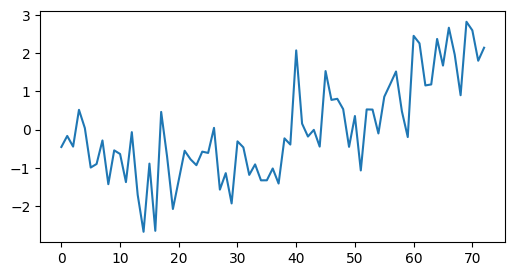

In [4]:
plt.figure(figsize=(6, 3))
plt.plot(np.nanmean(SAT_arctic_ts, axis=0))
np.nanmean(SAT_arctic_ts, axis=0)

In [5]:
lats1 = np.arange(-88.75, 88.751, 2.5)
lats2 = np.arange(-90, 92.5, 2.5)

print(lats1[44], lats2[44])

w1 = np.cos(np.deg2rad(lats1[44:]))[::-1]
w2 = np.cos(np.deg2rad(lats2[44:]))[::-1]

w1, w2

21.25 20.0


(array([0.02181489, 0.06540313, 0.10886687, 0.15212339, 0.19509032,
        0.23768589, 0.27982901, 0.32143947, 0.36243804, 0.40274669,
        0.44228869, 0.48098877, 0.51877326, 0.55557023, 0.59130965,
        0.62592347, 0.65934582, 0.69151306, 0.72236396, 0.75183981,
        0.77988448, 0.8064446 , 0.83146961, 0.85491187, 0.87672676,
        0.89687274, 0.91531148, 0.93200787]),
 array([6.12323400e-17, 4.36193874e-02, 8.71557427e-02, 1.30526192e-01,
        1.73648178e-01, 2.16439614e-01, 2.58819045e-01, 3.00705800e-01,
        3.42020143e-01, 3.82683432e-01, 4.22618262e-01, 4.61748613e-01,
        5.00000000e-01, 5.37299608e-01, 5.73576436e-01, 6.08761429e-01,
        6.42787610e-01, 6.75590208e-01, 7.07106781e-01, 7.37277337e-01,
        7.66044443e-01, 7.93353340e-01, 8.19152044e-01, 8.43391446e-01,
        8.66025404e-01, 8.87010833e-01, 9.06307787e-01, 9.23879533e-01,
        9.39692621e-01]))

In [6]:
SLP_weights

array([0.02181489, 0.06540313, 0.10886687, 0.15212339, 0.19509032,
       0.23768589, 0.27982901, 0.32143947, 0.36243804, 0.40274669,
       0.44228869, 0.48098877, 0.51877326, 0.55557023, 0.59130965,
       0.62592347, 0.65934582, 0.69151306, 0.72236396, 0.75183981,
       0.77988448, 0.8064446 , 0.83146961, 0.85491187, 0.87672676,
       0.89687274, 0.91531148, 0.93200787])

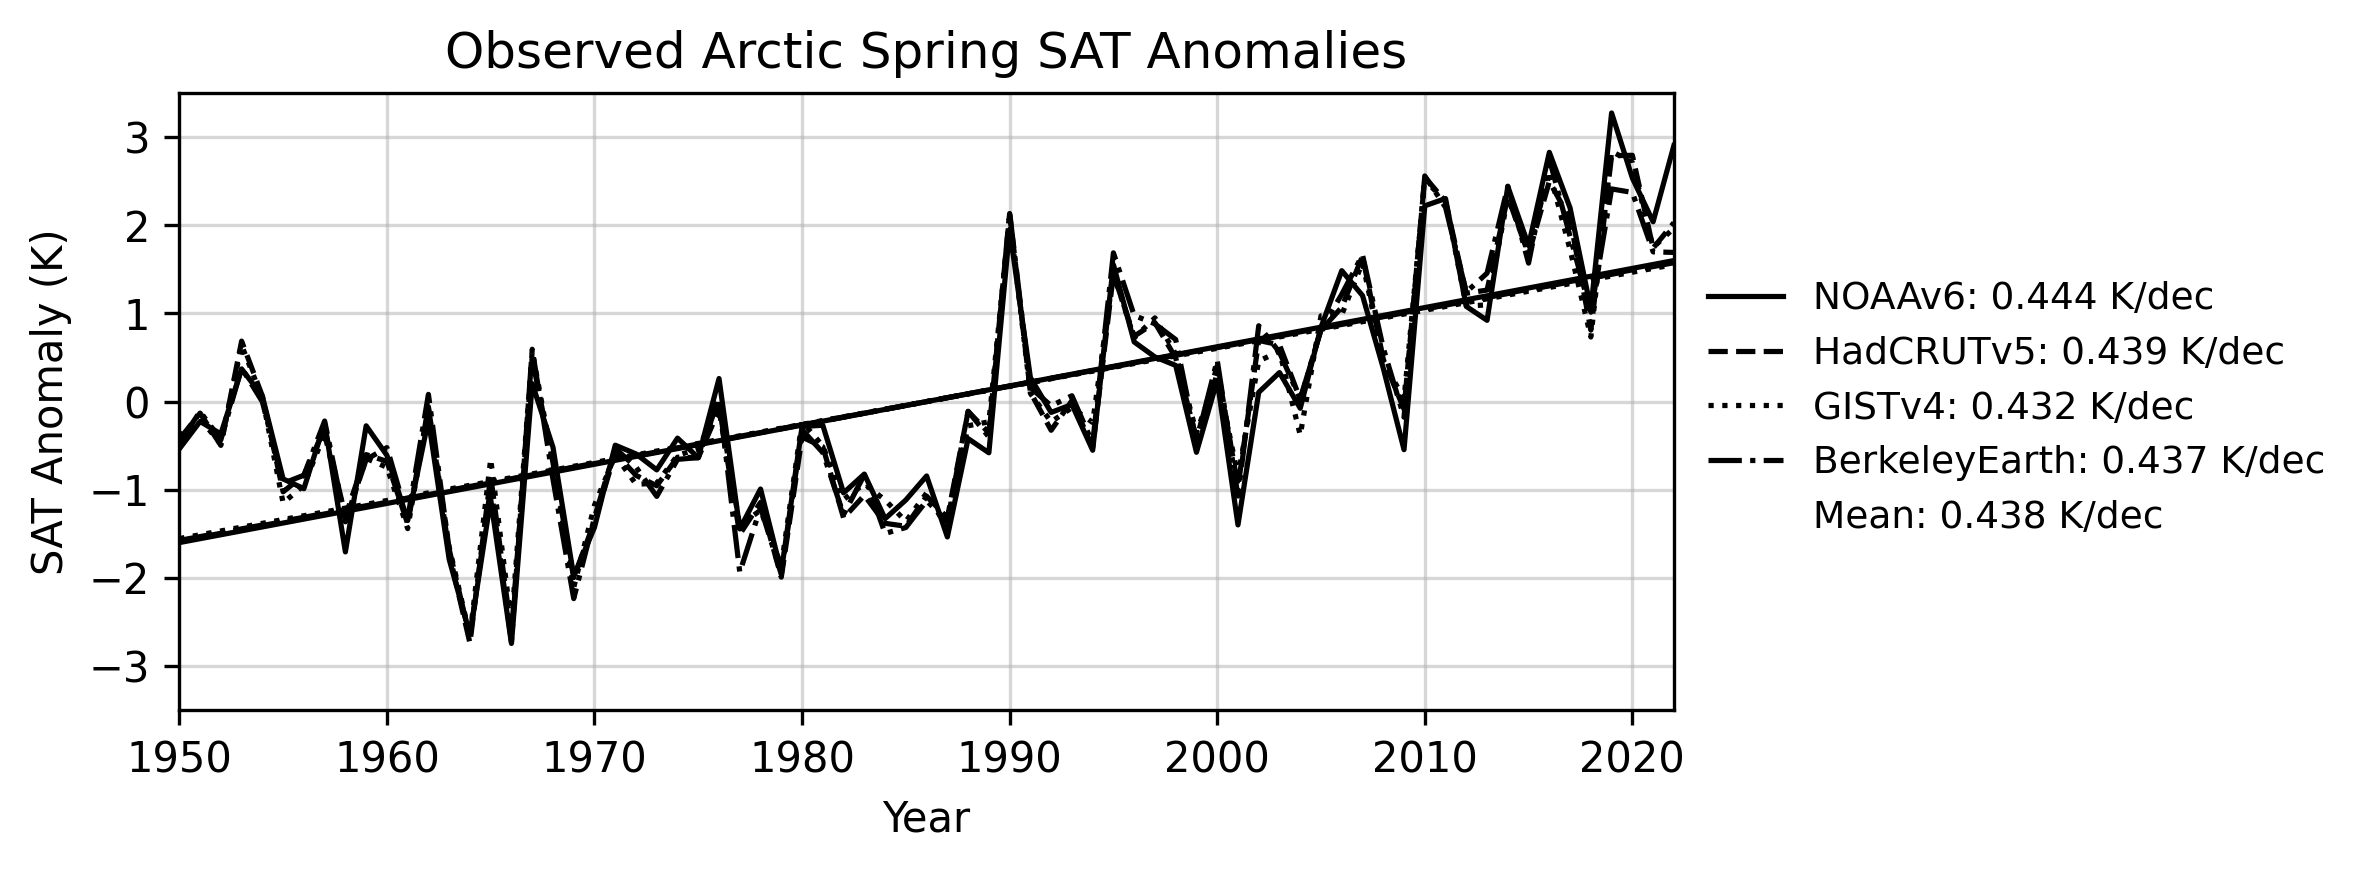

In [7]:
# Observational sets timeseries plot for comparison
plt.figure(figsize=(8, 3), dpi=300)
time = np.arange(1950, 2023, 1)

for i in range(len(SAT_arctic_ts)):
    obs_ts = SAT_arctic_ts[i]
    trend = stats.linregress(time/10, obs_ts)[0]
    plt.plot(years, obs_ts, label=f'{SAT_names[i]}: {trend:.3f} K/dec', color='k', linewidth=1.25, linestyle=linestyles[i])
    line = np.polyfit(time, obs_ts, deg=1)
    plt.plot(time, np.polyval(line, time), color='k', linewidth=1.25, linestyle=linestyles[i])

obs_mean = np.nanmean(SAT_arctic_ts, axis=0)
trend = stats.linregress(time/10, obs_mean)[0]
plt.plot([], [], ' ', label=f'Mean: {trend:.3f} K/dec')

plt.grid(alpha=0.5)
plt.xlim(1950, 2022)
plt.ylim(-3.5, 3.5)
plt.legend(fontsize=9, frameon=False, bbox_to_anchor=(1, 0.75))
plt.xlabel('Year')
plt.ylabel('SAT Anomaly (K)')
plt.title("Observed Arctic Spring SAT Anomalies")
plt.tight_layout()
# plt.savefig(f'./figures/finalv2/S5_Obs_Arctic_Timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

## Cross validation

In [8]:
# Define number of SLP predictors
num_predictors = int(input("num_predictors:"))

# Arrays to store results across LOO folds
total_variance_explained_cv = np.zeros((43, num_predictors))

# Leave-one-year-out cross-validation
loo = LeaveOneOut()

# Perform cross-validation
for fold in range(43):
    if fold == 3:  # Skip fold 3 (or leave out p=3)
        continue

    # Define train and test indices
    train_idx = [i for i in range(43) if i != fold]
    test_idx = [fold]

    total_variance_explained = np.zeros(num_predictors)

    # Perform dynamic adjustment for each SAT-SLP dataset combination
    for sat_idx in range(SAT_anoms_std.shape[0]):
        print(f'Working on {SAT_names[sat_idx]}')
        Y_train, Y_test = SAT_ts_std[sat_idx][train_idx], SAT_ts_std[sat_idx][test_idx]
        SAT_train, SAT_test = SAT_arctic_ts[sat_idx][train_idx], SAT_arctic_ts[sat_idx][test_idx]

        for slp_idx in range(SLP_anoms_std.shape[0]):
            print(f' > {SLP_names[slp_idx]}')
            X_train, X_test = SLP_anoms_std[slp_idx][train_idx], SLP_anoms_std[slp_idx][test_idx]

            Zs_train, Zs_test = [], []
            for n in range(num_predictors):
                X_train, Y_train, Z_train, _ = dynamic_adjustment(X_train, Y_train, weights=SLP_weights, decades=np.arange(len(train_idx))/10)
                Zs_train.append(Z_train)

                # Apply dynamic adjustment to test data (using only the test year)
                _, _, Z_test, _ = dynamic_adjustment(X_test, Y_test, weights=SLP_weights, decades=np.array([test_idx[0]])/10)
                Zs_test.append(Z_test)

            # Compute variance explained using the test data
            for i in range(len(Zs_train)):
                partial_regr = LinearRegression().fit(np.transpose(Zs_train[:i+1]), SAT_train)
                partial_regressed_test = partial_regr.predict(np.transpose(Zs_test[:i+1]))

                # Ensure correct shapes for Pearson correlation
                if len(partial_regressed_test) == len(SAT_test):
                    r2_tot = np.square(stats.pearsonr(partial_regressed_test.flatten(), SAT_test.flatten())[0])
                    total_variance_explained[i] = r2_tot * 100
                    print(f'   Component #{i+1}: {r2_tot*100:.1f}% of (test) variance')

    # Store results for this fold
    total_variance_explained_cv[fold, :] = total_variance_explained


KeyboardInterrupt



In [ ]:
# Plot total variance explained vs. number of components
plt.figure(figsize=(8, 5))
# plt.plot(range(1, max_components + 1), variance_explained * 100, marker='o', linestyle='-')
plt.xlabel("Number of Components")
plt.ylabel("Total Explained Variance (%)")
plt.title("Leave 'p' out Cross-Validation for Optimal Component Selection")
plt.grid(True)
plt.show()

## Pointwise regression

#### Methodology

1. Start with the anomaly spring-mean SAT data (time x lat x lon). Take cosine-latitude-weighted area-average: Y = Area-averaged SAT time-series. High pass filter Y to prevent fitting trends in the two fields.

2. Correlate Y with the SLP predictors z ((time, lat, lon), 20N and poleward) to form a one-point cross-correlation (CC) to serve as the weighting function w.

3. Now take the standardized, column (mean)-centered predictor SLP field X, cosine-latitude-weighted. Standardized X ensures the predictors are weighted by in accordance with their correlation with the predictand. This prevents predictors with large variances and low correlations from influencing the linear combinations.

4. Project onto the CC pattern to obtain a time-varying (time-series) index of the pattern (a PLS predictor z).

5. Now regress zout the predictor field X and the "unfiltered" predictand Y. This creates a set of residual variables that are now the basis for determining the next PLS predictor (if pursuing more than one).

6. To prevent overfitting, you only want to use a limited number of PLS predictors, determined through cross-validation. This is cumbersome for point-wise PLS regression because the optimal number of predictors varies from grid point to grid point.

In [8]:
# Define number of SLP predictors
num_predictors = int(input("Number of SLP Predictors:"))

# Arrays to save induced and residual components for uncertainty
SAT_induced_all, SAT_residual_all, SAT_residual_ds = [], [], []

# Arrays to save all regression plots and overall variance explained
regr_maps, SAT_regr_maps, variance_explained, total_variance_explained = [], [], [], []

# Perform dynamic adjustment for each SAT-SLP dataset combination and average
for sat_idx in range(SAT_anoms_std.shape[0]):  # Loop over SAT datasets
    print('Working on', SAT_names[sat_idx])
    Y = SAT_ts_std[sat_idx].copy()
    SAT_ts = SAT_arctic_ts[sat_idx].copy()

    # Arrays for SAT dataset averages
    SAT_induced_one = []
    SAT_residual_one = []

    for slp_idx in range(SLP_anoms_std.shape[0]):  # Loop over SLP datasets
        print('  -->', SLP_names[slp_idx])
        X = SLP_anoms_std[slp_idx].copy()

        # print('X', np.shape(X))
        # print('Y', np.shape(Y))
        # print('SAT_ts', np.shape(SAT_ts))

        # Perform dynamic adjustment
        Zs, CC_maps = [], []
        for n in range(num_predictors):
            X, Y, Z, CC = dynamic_adjustment(X, Y, weights=SLP_weights)
            Zs.append(Z)
            CC_maps.append(CC)

        # print('Zs', np.shape(Zs))
        # print('CC_maps', np.shape(CC_maps))

        # Regress Z out of the "unfiltered" predictand (dynamically induced)
        SAT_regr = LinearRegression().fit(np.transpose(Zs), SAT_ts)
        SAT_induced = SAT_regr.predict(np.transpose(Zs))
        SAT_induced_all.append(SAT_induced)

        # Adjust SAT timeseries by removing the induced component
        SAT_residual = SAT_ts - SAT_induced
        SAT_residual_one.append(SAT_residual)
        SAT_residual_all.append(SAT_residual)

        # Find explained variance from each SLP predictor
        for i in range(len(Zs)):
            if i == 0:
                target = SAT_ts

            # Find explained variance
            r2 = np.square(stats.pearsonr(Zs[i], target)[0])
            variance_explained.append(r2*100)

            # Remove from target to update
            regr = stats.linregress(Zs[i], target)
            recr = regr[1] + regr[0] * Zs[i]
            target = target - recr

            # Find total explained variance
            partial_regr = LinearRegression().fit(np.transpose(Zs[:(i+1)]), SAT_ts)
            partial_regressed = partial_regr.predict(np.transpose(Zs[:(i+1)]))
            r2_tot = np.square(stats.pearsonr(partial_regressed, SAT_ts)[0])
            total_variance_explained.append(r2_tot*100)

            # Print variance
            print('      Component '+str(i+1)+': '+str(r2*100)[:4]+'% of residual variance | Total: '+str(r2_tot*100)[:4]+'%')

        # Standardize the entire Z timeseries
        Zs_std = np.divide(Zs, np.nanstd(Zs, axis=1)[:, np.newaxis])

        # Get the regression maps
        for i, predictor in enumerate(Zs_std):
            if i == 0:
                SLP_map = SLP_anoms_spring_20N[slp_idx]
            regr_map, SLP_variability_regressed_out = reg_finder(SLP_map, predictor)
            SLP_map = np.swapaxes(SLP_variability_regressed_out, 1, 2)
            regr_maps.append(regr_map)

        # Get SAT regression maps?
        for i, predictor in enumerate(Zs_std):
            if i == 0:
                SAT_map = SAT_anoms_spring_20N[sat_idx]
            SAT_regr_map, SAT_variability_regressed_out = reg_finder(SAT_map, predictor)
            SAT_map = np.swapaxes(SAT_variability_regressed_out, 1, 2)
            SAT_regr_maps.append(SAT_map)

    # Compute SAT dataset averages
    SAT_residual_ds.append(np.nanmean(SAT_residual_one, axis=0))

# Compute the average of all combinations
SAT_residual_average = np.nanmean(SAT_residual_ds, axis=0)

print('Done!')

Number of SLP Predictors: 3


Working on NOAAv6
  --> ERA5
      Component 1: 22.9% of residual variance | Total: 22.9%
      Component 2: 15.1% of residual variance | Total: 34.6%
      Component 3: 5.17% of residual variance | Total: 37.9%
Working on HadCRUTv5
  --> ERA5
      Component 1: 25.5% of residual variance | Total: 25.5%
      Component 2: 17.1% of residual variance | Total: 38.3%
      Component 3: 6.38% of residual variance | Total: 42.2%
Working on GISTv4
  --> ERA5
      Component 1: 25.5% of residual variance | Total: 25.5%
      Component 2: 18.0% of residual variance | Total: 38.9%
      Component 3: 6.08% of residual variance | Total: 42.7%
Working on BerkeleyEarth
  --> ERA5
      Component 1: 23.5% of residual variance | Total: 23.5%
      Component 2: 15.7% of residual variance | Total: 35.6%
      Component 3: 5.59% of residual variance | Total: 39.2%
Done!


In [10]:
# For plot...

# Convert lists to arrays
SAT_induced_all = np.reshape(np.concatenate(SAT_induced_all, axis=0), (4, 73))
SAT_residual_all = np.reshape(np.concatenate(SAT_residual_all, axis=0), (4, 73))

# Get mean timeseries
mean_tot_ts = np.nanmean(SAT_arctic_ts, axis=0)
mean_ind_ts = np.nanmean(SAT_induced_all, axis=0)
mean_res_ts = np.nanmean(SAT_residual_all, axis=0)

# Calculate 1980-2022 trends and autocorrelated uncertainty
time = np.arange(1980, 2023, 1)
# time = (time - time[0]) / 10
time_series = [mean_tot_ts[30:], mean_ind_ts[30:], mean_res_ts[30:]]

trend_lines, trend_labels = [], []
for ts in time_series:
    # Find linear regression from 1980-2022

    # Ordinary least squares regression
    regression = stats.linregress(time, ts)
    slope = regression[0]
    intercept = regression[1]

    trend_line = intercept + slope * time
    trend_lines.append(trend_line)

    # Find residuals from trend line
    errors = ts - trend_line
    time_errors = time - np.nanmean(time)

    # Find degrees of freedom with autocorrelation
    N = len(ts)
    r1_autocorrelation = stats.pearsonr(ts[1:], ts[:-1])[0]
    if r1_autocorrelation < 0:
        r1_autocorrelation = 0
    N_star = N * ((1 - r1_autocorrelation) / (1 + r1_autocorrelation))

    # Find squared error in x and y
    sum_squared_error_res = np.sum(np.square(errors))
    var_errors = (1 / N_star) * sum_squared_error_res
    time_squared_error = np.sum(np.square(time_errors))

    # Find t-statistic
    sigma_slope_squared = var_errors / time_squared_error
    sa = np.sqrt(sigma_slope_squared)

    # Get critical t value (95%)
    tcrit = stats.t.ppf(1 - 0.025, N_star)

    # Find confidence interval of trend
    ci_trend = tcrit * sa

    # Get trend label
    trend_label = f"Trend: {slope*10:.3f} ± {(ci_trend)*10:.3f} K/dec"
    print(trend_label)
    trend_labels.append(trend_label)

Trend: 0.786 ± 0.461 K/dec
Trend: 0.261 ± 0.242 K/dec
Trend: 0.525 ± 0.245 K/dec


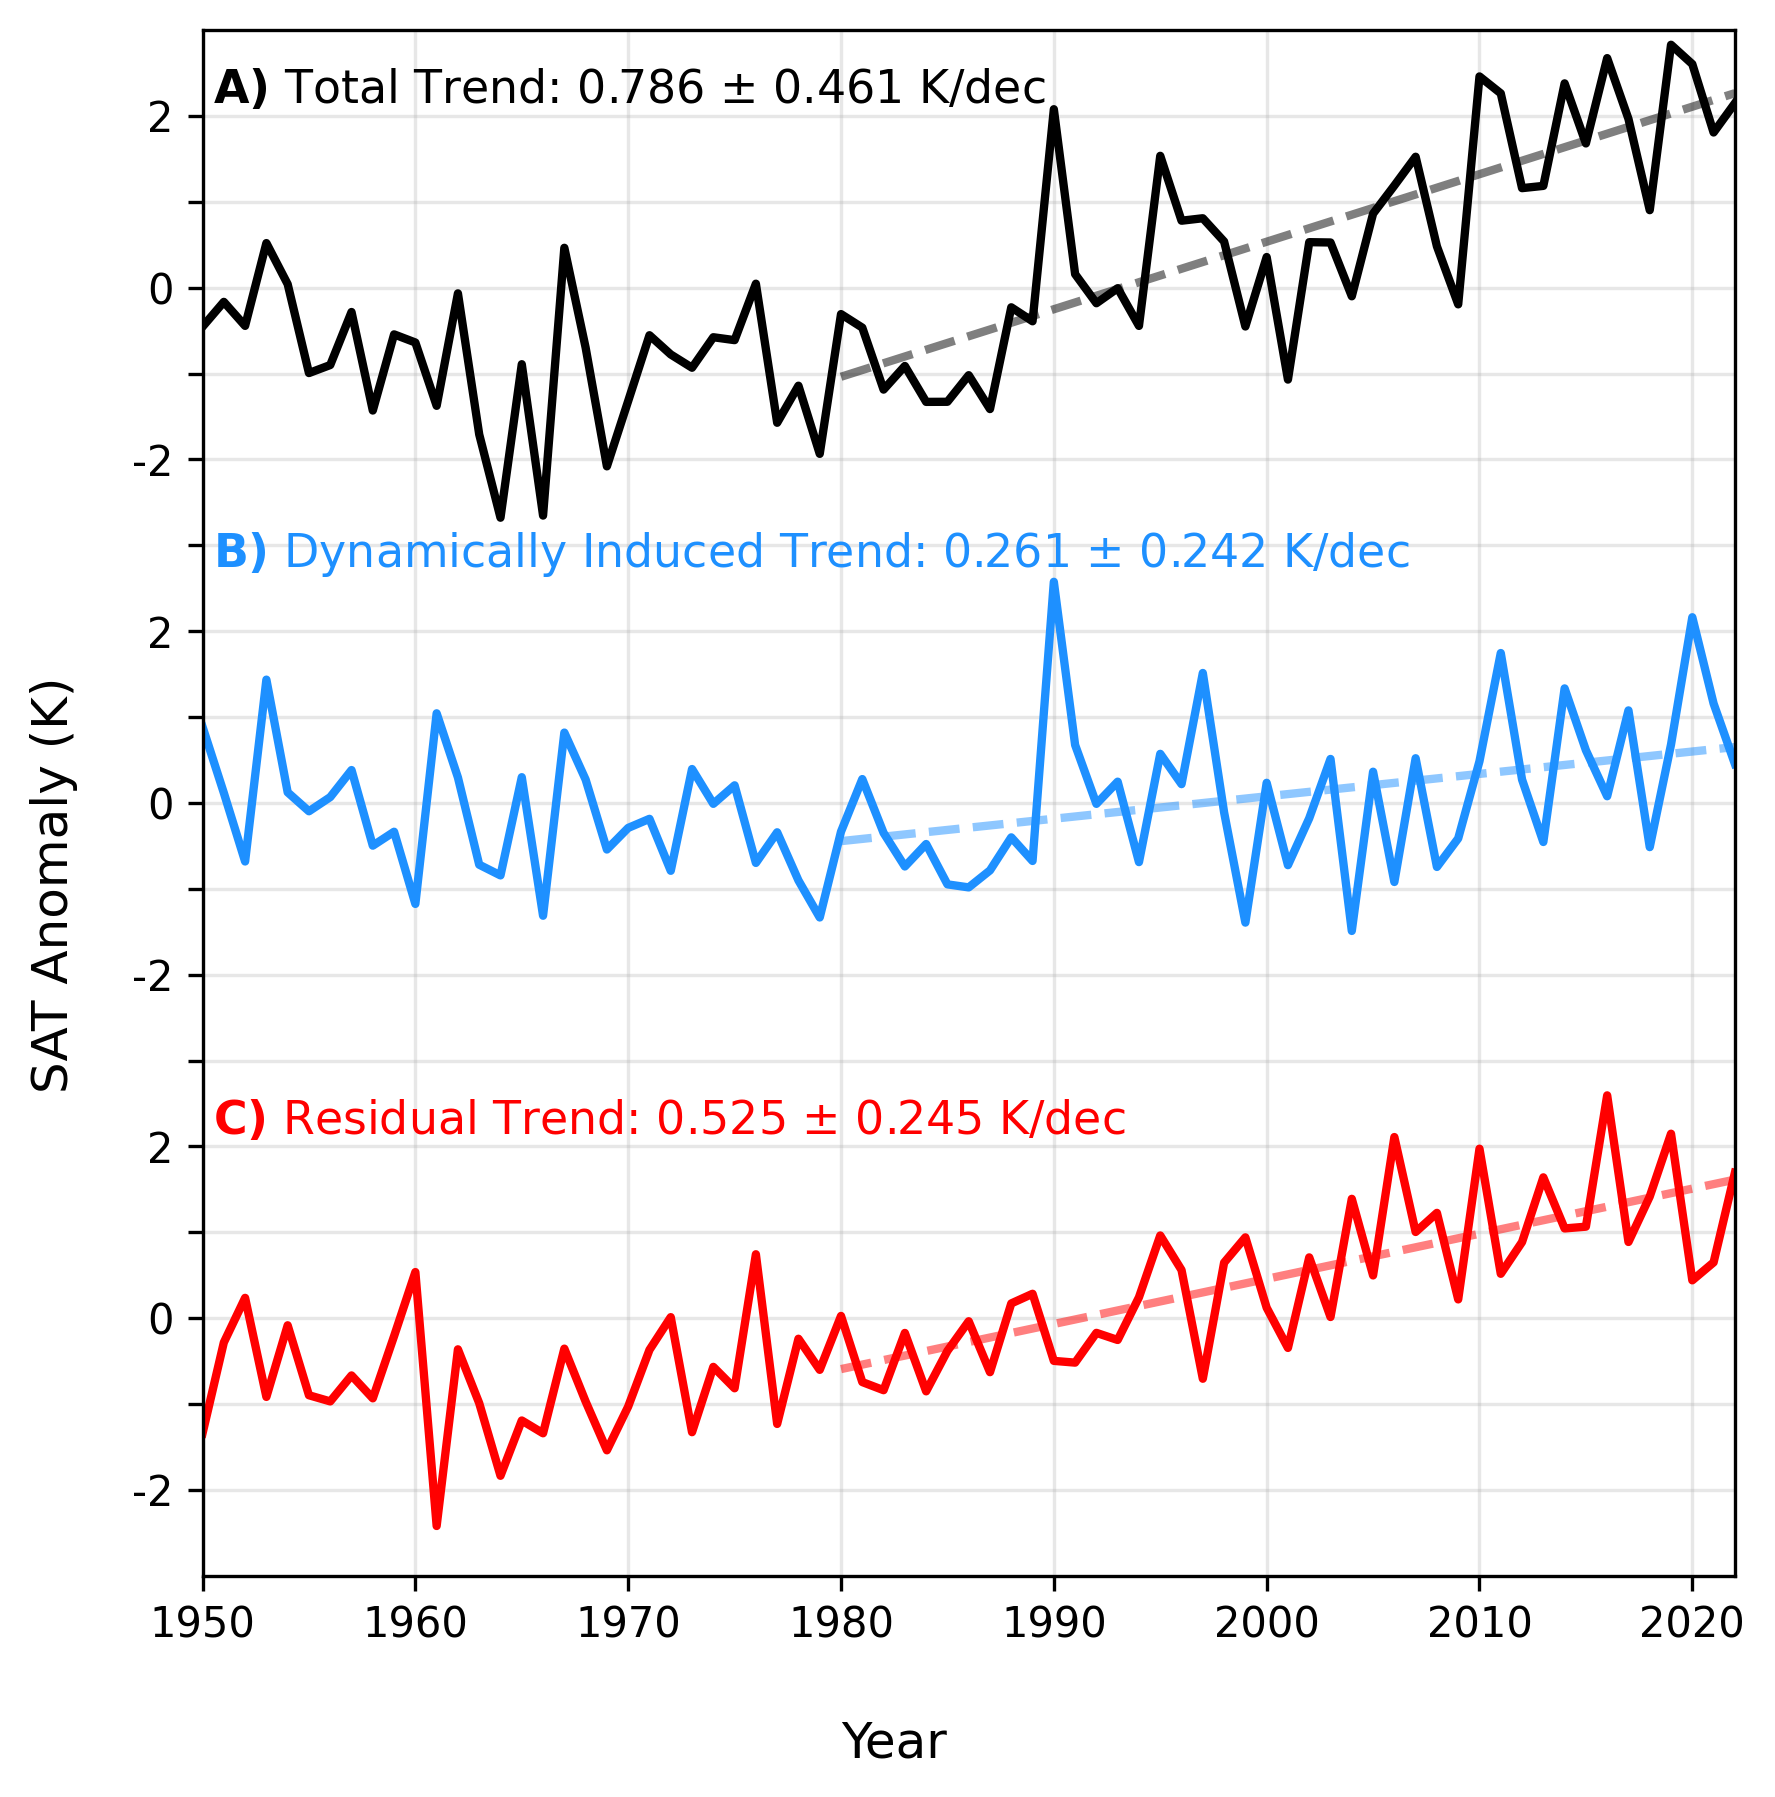

In [11]:
# Create plot
fig, axes = plt.subplots(figsize=(6, 6), dpi=300)

# Plot components with trends
axes.plot(years, mean_tot_ts+12, color='k', lw=2)
axes.plot(time, trend_lines[0]+12, color='k', alpha=0.5, lw=2, linestyle='--')

axes.plot(years, mean_tot_ts-SAT_residual_average+6, color='dodgerblue', lw=2)
axes.plot(time, trend_lines[1]+6, color='dodgerblue', alpha=0.5, lw=2, linestyle='--')

axes.plot(years, SAT_residual_average, color='red', lw=2)
axes.plot(time, trend_lines[2], color='red', alpha=0.5, lw=2, linestyle='--')


# Trend text labels
label_A, label_B, label_C = "A", "B", "C"
axes.text(1950.5, 14.15, r"$\bf{"+str(label_A)+")}$"+f' Total {trend_labels[0]}',
          color='k', fontsize=11, transform=axes.transData)
axes.text(1950.5, 8.75, r"$\bf{"+str(label_B)+")}$"+f' Dynamically Induced {trend_labels[1]}',
          color='dodgerblue', fontsize=11, transform=axes.transData)
axes.text(1950.5, 2.15, r"$\bf{"+str(label_C)+")}$"+f' Residual {trend_labels[2]}',
          color='red', fontsize=11, transform=axes.transData)

# Plot customizations
axes.grid(alpha=0.3)
axes.set_xlim(1950, 2022)
axes.set_ylim(-3, 15)

# Repeating y-axis
axes.set_yticks([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
axes.set_yticklabels(["-2", "", "0", "", "2", "",
                      "-2", "", "0", "", "2", "",
                      "-2", "", "0", "", "2"])

# Labels
fig.supxlabel('Year')
fig.supylabel('SAT Anomaly (K)')

plt.tight_layout()
# plt.savefig(f'./figures/finalv2/Fig7_1980_2022_Dyn_Adj.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
np.shape(regr_maps)

(48, 144, 28)

In [13]:
# Find mean of each component's regression map
regr_maps_comp = np.reshape(regr_maps, (4, int(num_predictors), 144, 28))
regr_maps_swap = np.swapaxes(regr_maps_comp, 2, 3)
regr_maps_average = np.nanmean(regr_maps_swap, axis=0)
regr_maps_average.shape

(12, 28, 144)

In [14]:
# Variance arrays
var = np.reshape(np.array(variance_explained), (4, int(num_predictors)))
tot_var = np.reshape(np.array(total_variance_explained), (4, int(num_predictors)))

# Convert to float
var = var.astype(float)
tot_var = tot_var.astype(float)

# Get mean by dynamic adjustment
var_mean = np.nanmean(var, axis=0)
tot_mean = np.nanmean(tot_var, axis=0)
var_mean, tot_mean

(array([24.4041797 , 16.52848314,  5.80874455,  7.89280924,  9.31295221,
        10.38315081, 14.39155064, 23.76317861, 31.7004652 , 29.68223615,
        22.93701925, 24.77314032]),
 array([24.4041797 , 36.88635145, 40.54471151, 45.23445325, 50.33528489,
        55.48296192, 61.94123164, 70.99409716, 80.16985583, 86.01807414,
        89.23058585, 91.95343197]))

In [15]:
exp = [tot_mean[0], tot_mean[1]-tot_mean[0], tot_mean[2]-tot_mean[1]]
exp

[24.404179701333135, 12.48217175362062, 3.6583600523127586]

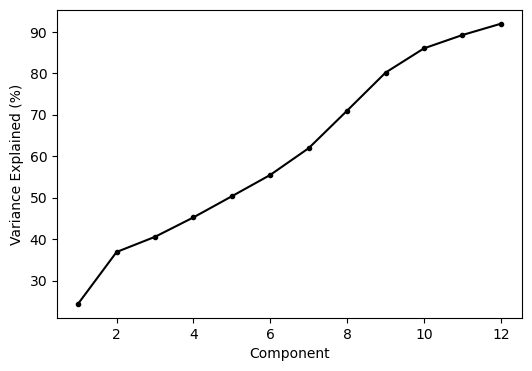

In [17]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, int(num_predictors)+1), tot_mean, marker='.', color='k')
plt.xlabel('Component')
plt.ylabel('Variance Explained (%)')
plt.show()

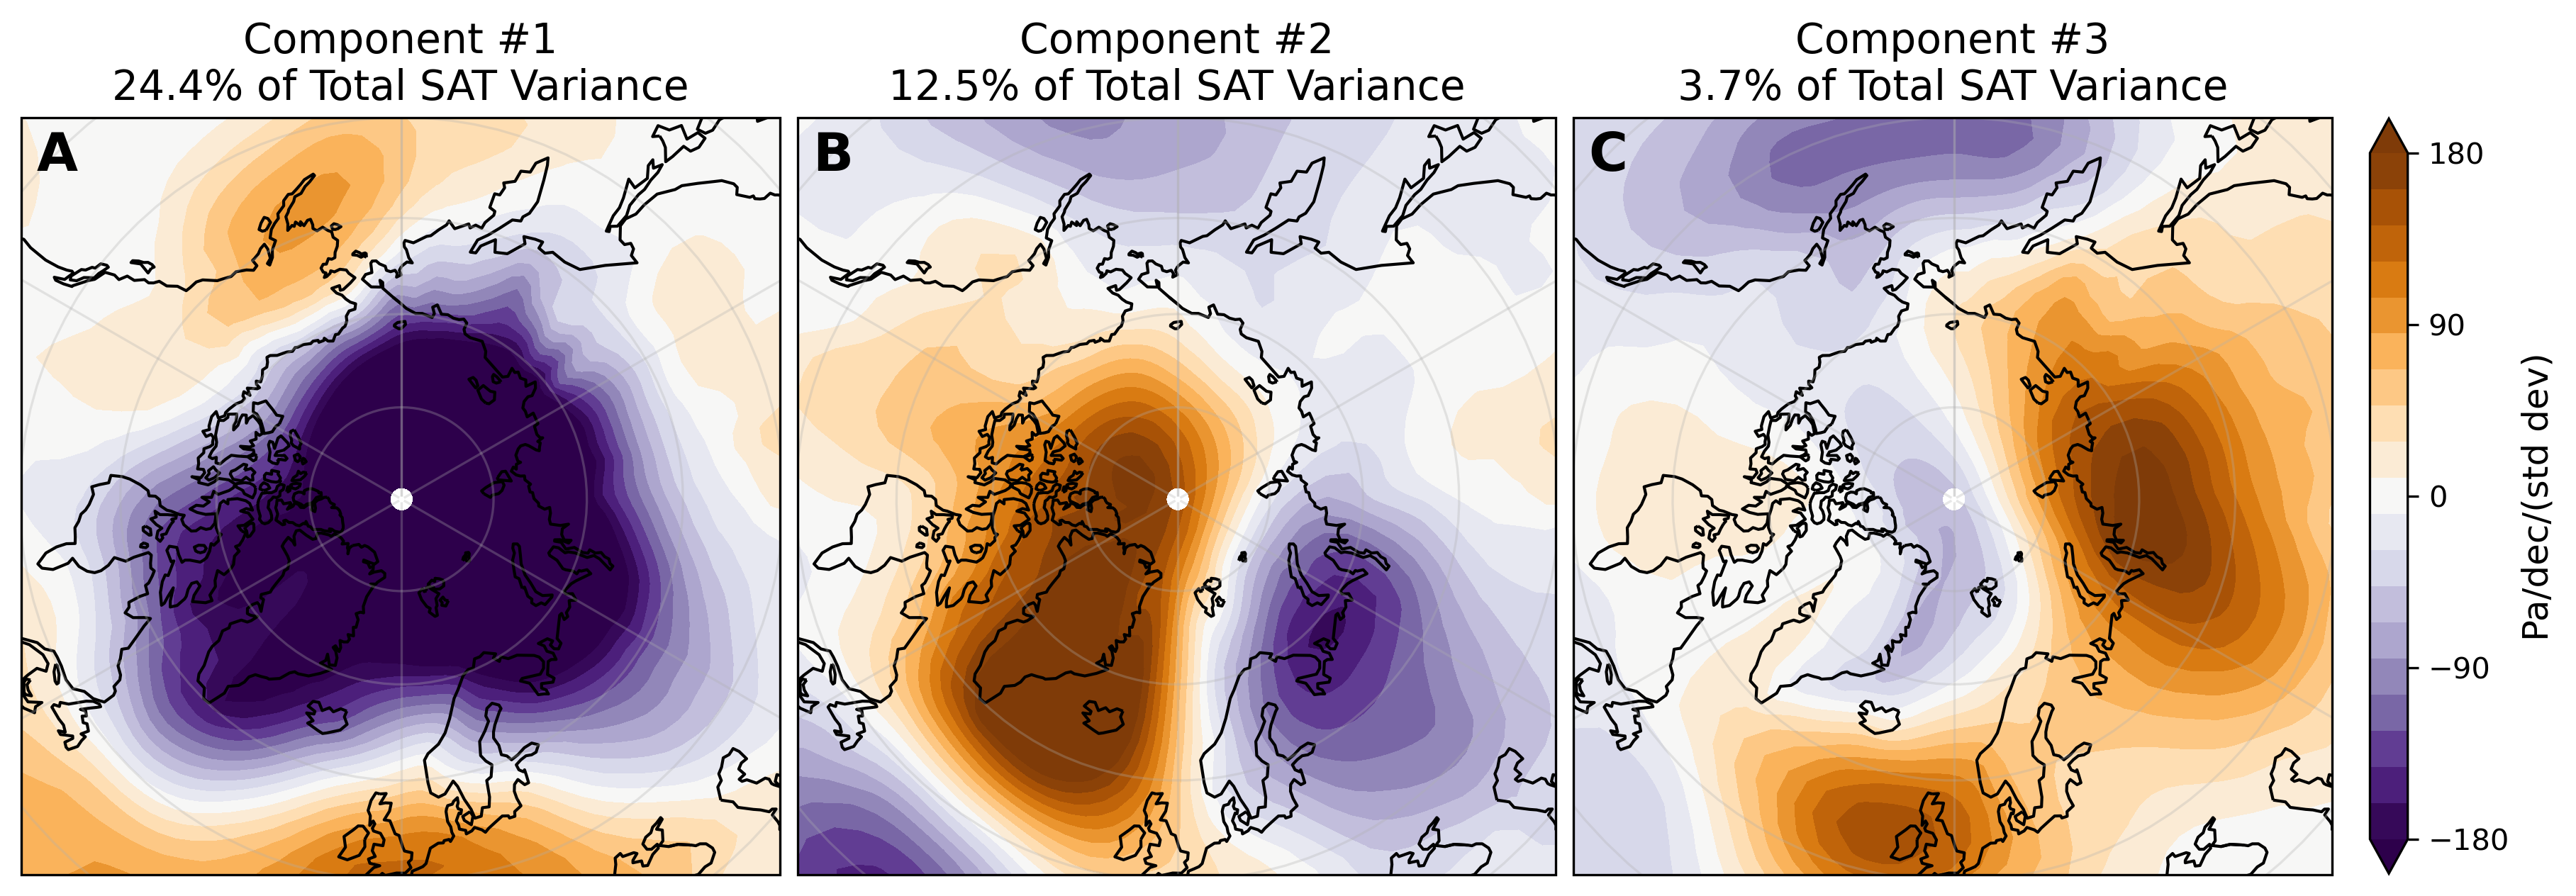

In [25]:
# Plot regression coefficient map
fig, axes = plt.subplots(1, 3, figsize=(12, 6), constrained_layout=True, dpi=300, subplot_kw={'projection': ccrs.NorthPolarStereo()})

labels = ['A', 'B', 'C']

for i, axs in enumerate(axes):
    map_cyclic, lon = add_cyclic_point(regr_maps_average[i], coord=lons)

    im = axs.contourf(lon, lats[44:],
                      map_cyclic,
                      cmap='PuOr_r',
                      extend='both',
                      levels=np.linspace(-180, 180, 20),
                      transform=ccrs.PlateCarree())

    axs.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
    axs.set_title(f'Component #{i+1}\n{exp[i]:.1f}% of Total SAT Variance', fontsize=14)
    axs.text(0.02, 0.93, labels[i], transform=axs.transAxes, fontsize=18, fontweight='bold')
    axs.gridlines(alpha=0.3)
    axs.coastlines()

cbar = plt.colorbar(im, ax=axes[2], location='right', ticks=np.linspace(-180, 180, 5), shrink=0.6, aspect=20)
cbar.set_label('Pa/dec/(std dev)', fontsize=12)

# plt.savefig(f'./figures/finalv2/Fig8_1980_2022_SLP_Regressed_onto_PLS_Predictors.png', dpi=300, bbox_inches='tight')
plt.show()

### Component and Observation Comparison

In [121]:
# Get Observations: SLP data
paths = glob.glob('/glade/work/skygale/training-data/seasonal/observations/slp/*')

obs_globe_spatial_trends = []
for path in paths:
    ds = xr.open_dataset(path).DATA
    obs_globe_spatial_trends.append(ds)

# Calculate mean spatial pressure trends
OBS_globe_spatial_trends = np.nanmean(obs_globe_spatial_trends, axis=0)

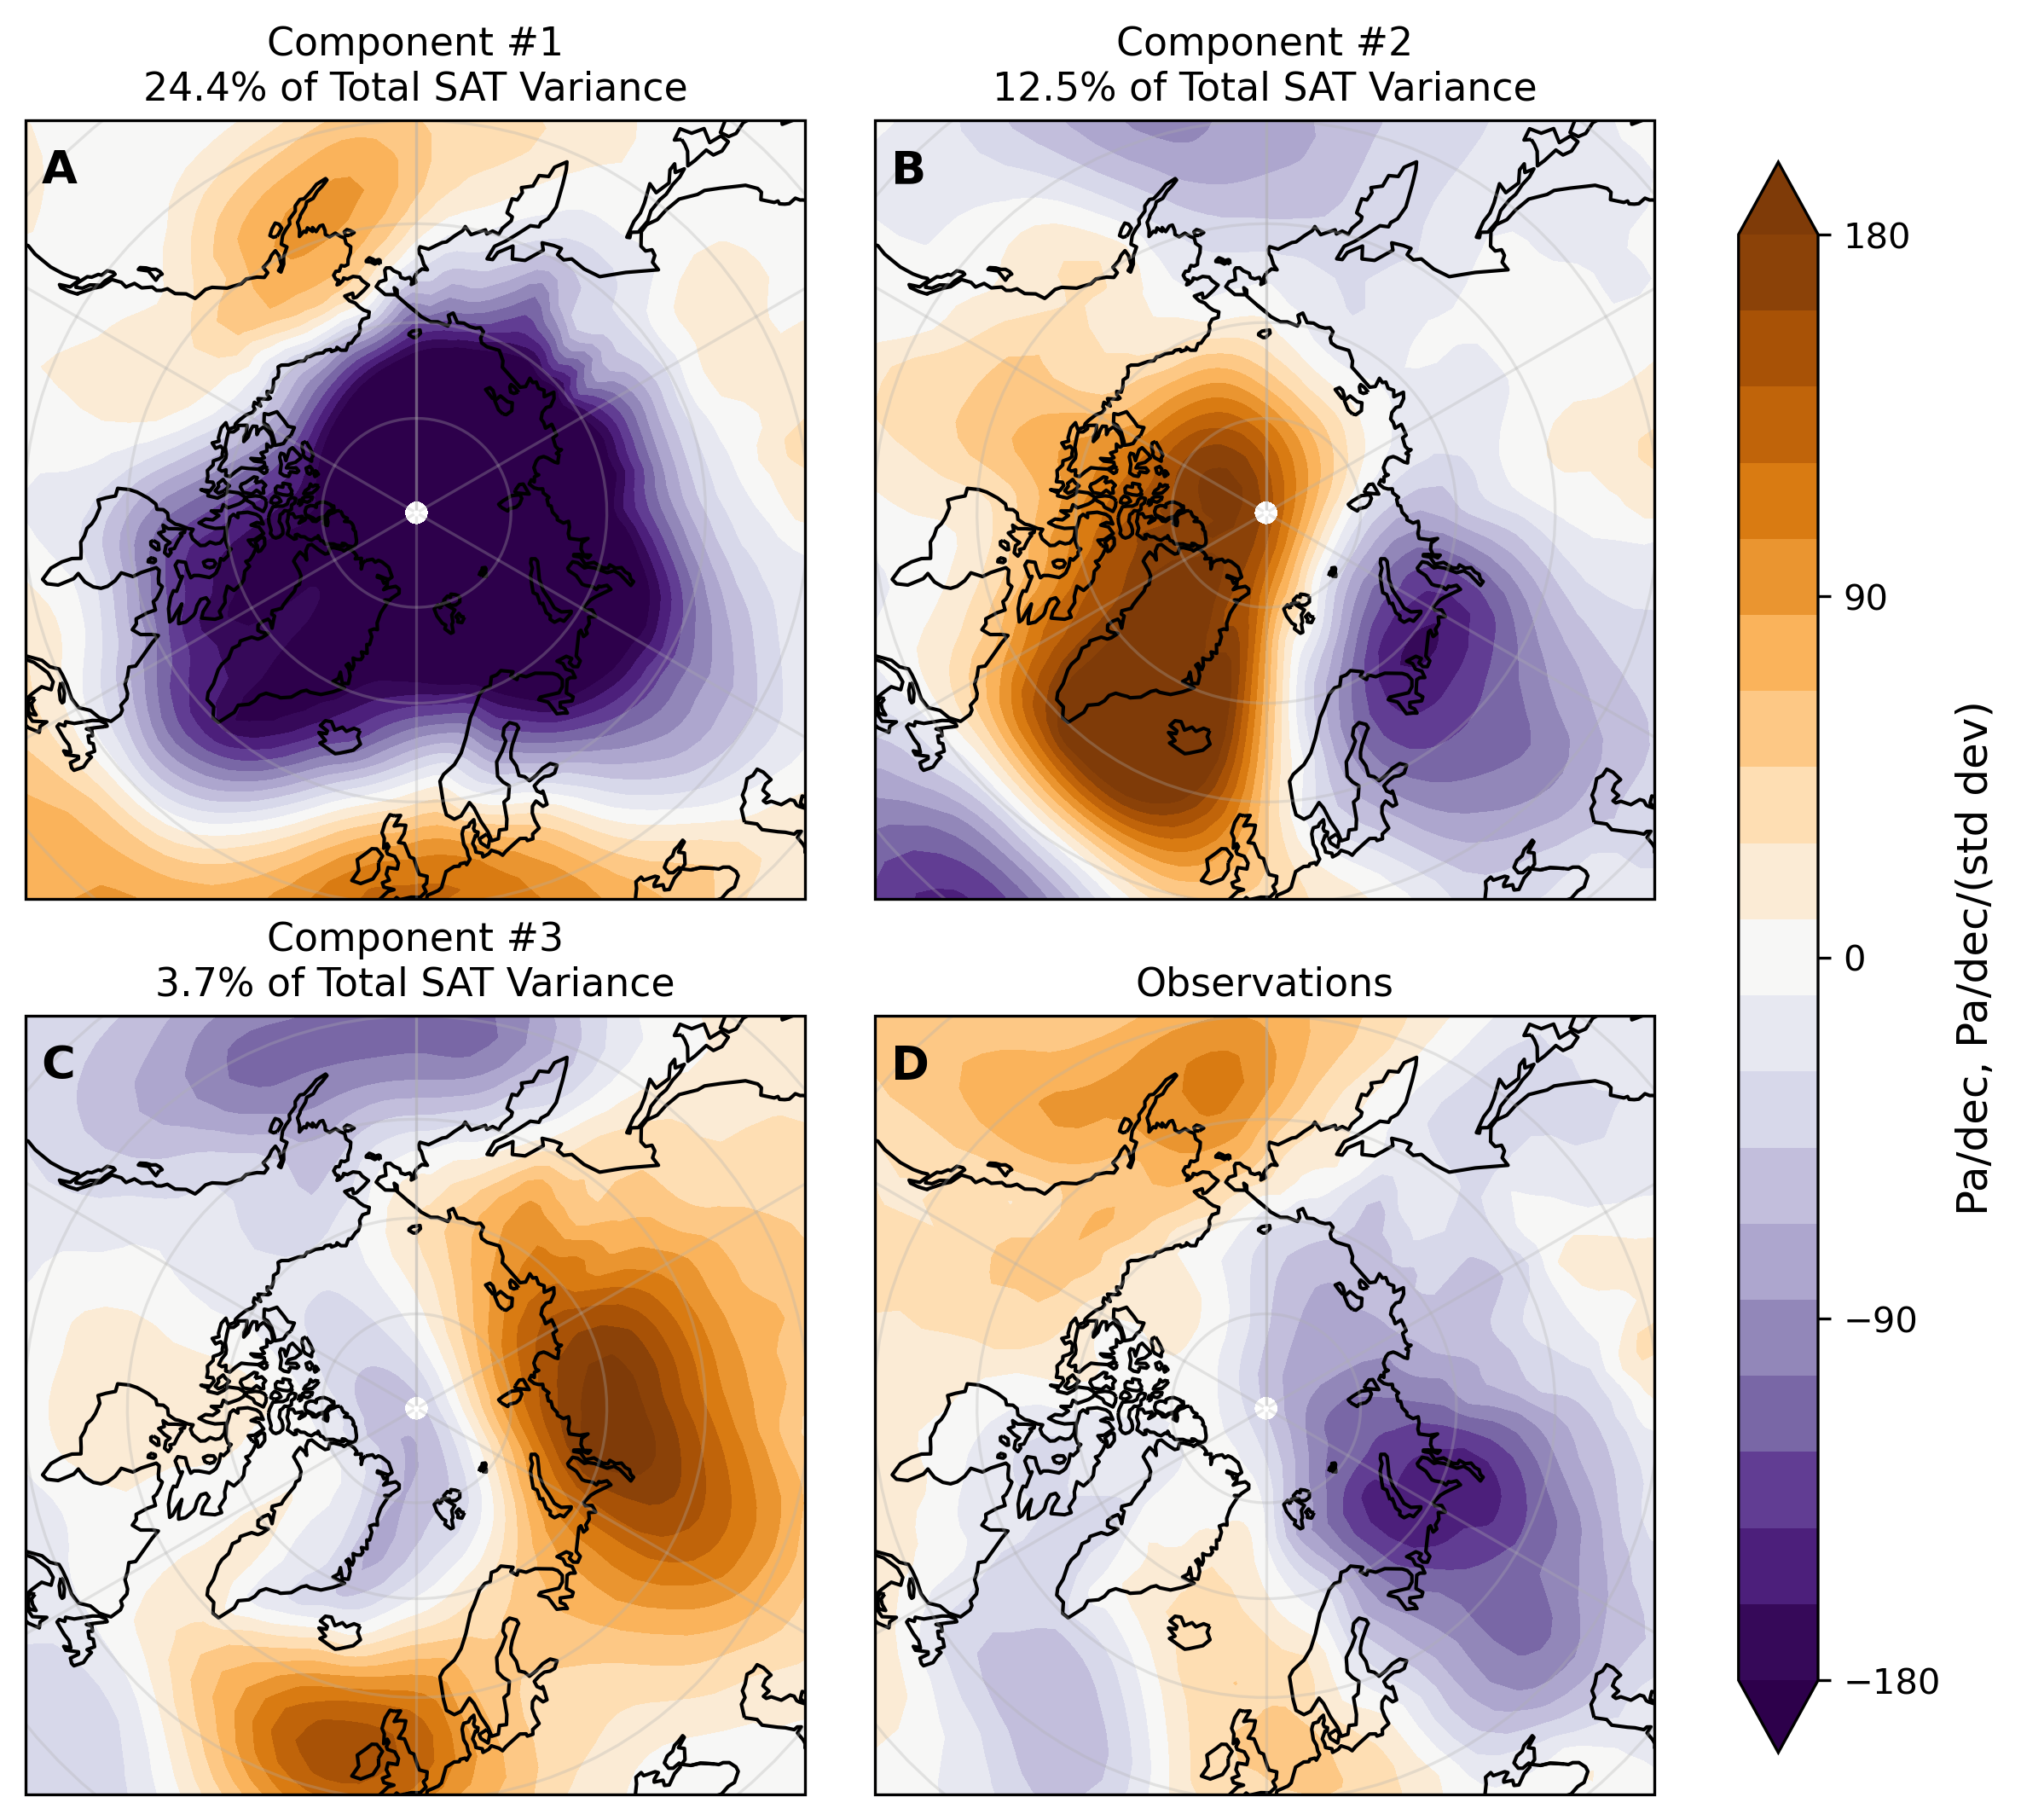

In [129]:
# Plot regression map
fig, axes = plt.subplots(2, 2, figsize=(8, 7), constrained_layout=True, dpi=300, subplot_kw={'projection': ccrs.NorthPolarStereo()})
axes = axes.ravel()

labels = ['A', 'B', 'C', 'D']
levels = np.linspace(-180, 180, 20)

for i, axs in enumerate(axes[:3]):
    map_cyclic, lon = add_cyclic_point(regr_maps_average[i], coord=lons)
    axs.contourf(lon, lats[44:], map_cyclic,
                 cmap='PuOr_r',
                 extend='both',
                 levels=levels,
                 transform=ccrs.PlateCarree())
    axs.set_title(f'Component #{i+1}\n{exp[i]:.1f}% of Total SAT Variance', fontsize=11)

map_cyclic, lon = add_cyclic_point(OBS_globe_spatial_trends[2], coord=lons)
im = axes[3].contourf(lon, lats,
                      map_cyclic,
                      cmap='PuOr_r',
                      extend='both',
                      levels=levels,
                      transform=ccrs.PlateCarree())
axes[3].set_title('Observations', fontsize=11)

for i, axs in enumerate(axes):
    axs.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
    axs.text(0.02, 0.92, labels[i], transform=axs.transAxes, fontsize=13, fontweight='bold')
    axs.gridlines(alpha=0.3)
    axs.coastlines()

cbar = plt.colorbar(im, ax=axes, location='right', aspect=20, shrink=0.95, ticks=np.linspace(-180, 180, 5))
cbar.set_label('Pa/dec, Pa/dec/(std dev)', fontsize=12)

# plt.savefig('./figures/final/S7_Component_Obs_Comparison.png', dpi=300, bbox_inches='tight')
plt.show()